explore the topic difference of countries after remove the co-funded publications that are funded by a specific country

In [1]:
import pandas as pd
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick

In [2]:
pubs_path="../../data/nf_folder/Data/DerivedData/CleanedRawData/pubs_author_funder.csv"
cntry_info_path="../../data/nf_folder/Data/AdditionalData/country_metadata.csv"
flag_path='../../data/nf_folder/Data/AdditionalData/country_WoS_ECI_WB_flags.tsv'

In [3]:
dislevel=pd.read_csv("../../data/nf_folder/Data/AdditionalData/discipline_classification.csv")
dislevel=dislevel[['level_1','level_3']]
dislevel=dislevel.rename(columns={'level_1':'disname','level_3':'level'})
dislevel.head()

,disname,level
0,Fine Arts & Architecture,Arts and Humanities
1,Performing Arts,Arts and Humanities
2,Agricult & Food Science,Natural Sciences
3,Botany,Natural Sciences
4,Dairy & Animal Science,Natural Sciences


In [11]:
dislevel=pd.read_csv("../../data/nf_folder/Data/AdditionalData/discipline_classification.csv")
dislevel

,abbrev,level_1,level_2,level_3
0,Fine Arts/Arch,Fine Arts & Architecture,Arts,Arts and Humanities
1,Perf. Arts,Performing Arts,Arts,Arts and Humanities
2,Agr. & Food Sci.,Agricult & Food Science,Biology,Natural Sciences
3,Botany,Botany,Biology,Natural Sciences
4,Dairy&Animal Sci.,Dairy & Animal Science,Biology,Natural Sciences
...,...,...,...,...
139,Planning & Urban Studies,Planning & Urban Studies,Social Sciences,Social Sciences
140,Political Sci. & Public Admin.,Political Science and Public Administration,Social Sciences,Social Sciences
141,Sci. Studies,Science studies,Social Sciences,Social Sciences
142,Sociology,Sociology,Social Sciences,Social Sciences


In [11]:
discode=pd.read_csv("../../data/nf_folder/Data/AdditionalData/discipline_code.csv")
discode=discode.rename(columns={'Code_Discipline':'dis','ESpecialite':'disname'})
discode.head()

,dis,disname
0,1,Agricult & Food Science
1,2,Botany
2,3,Dairy & Animal Science
3,4,Ecology
4,5,Entomology


In [16]:
dismeta=discode.merge(dislevel, on='disname')

In [3]:
paf = pd.read_csv(pubs_path)
paf['author_country'] = paf['author_country'].apply(literal_eval)
paf['funder_country'] = paf['funder_country'].apply(
    lambda x:literal_eval(x) if pd.notnull(x) else "Not-Funded")
paf.head()

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,author_country,funder_country,discipline,year,rel_citation,citation
0,30507292,[Turkey],[Turkey],77,2009,0.485,6
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9
2,30574691,[Russia],[Russia],83,2009,0.312,4
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3


In [4]:
paf['author_distinct']=paf['author_country'].apply(lambda x:list(set(x)))
paf['funder_distinct']=paf['funder_country'].apply(
    lambda x:list(set(x)) if x!='Not-Funded' else 'Not-Funded')

In [5]:
paf.tail()

,id,author_country,funder_country,discipline,year,rel_citation,citation,author_distinct,funder_distinct
12759123,65301180,[Pakistan],Not-Funded,89,2018,0.000,0,[Pakistan],Not-Funded
12759124,65301286,"[Singapore, Singapore]",Not-Funded,44,2017,0.264,1,[Singapore],Not-Funded
12759125,65301288,[Iran],Not-Funded,96,2017,0.000,0,[Iran],Not-Funded
12759126,65301295,[Israel],Not-Funded,96,2017,0.000,0,[Israel],Not-Funded
12759127,65301297,[United Kingdom],Not-Funded,2,2018,1.992,2,[United Kingdom],Not-Funded


In [6]:
# label out whether the paper is cofunded by countries
paf['cofund']=paf['funder_distinct'].apply(lambda x: 1 if x!='Not-Funded' and len(x)>1 else 0)

In [7]:
pub_fund=paf[['id','funder_distinct','cofund']].explode('funder_distinct')
pub_fund.head()

,id,funder_distinct,cofund
0,30507292,Turkey,0
1,30574690,United States,0
2,30574691,Russia,0
3,30585095,Spain,0
4,30585097,Spain,0


In [8]:
def construct_profile(data,colname):
    profile=[]
    for ind, row in data.iterrows():
        year=row['year']
        dis=row['discipline']
        authors=row['author_distinct']
        num_aut=len(authors)
        for a in authors:
            profile.append([a,year,dis,1/num_aut])
    profile_df=pd.DataFrame(profile,columns=['cntry','year','dis','frac'])
    profile_df=profile_df.groupby(['cntry','dis'])['frac'].sum().reset_index(name=colname)
    return profile_df

In [9]:
raw_profile=construct_profile(paf,'total')

In [12]:
def filter_data(paf,paf_exp,cntry):
    removelist=paf_exp[(paf_exp.funder_distinct==cntry)&(paf_exp.cofund==1)].id.tolist()
    paf_removed=paf[paf.id.isin(removelist)]
    return paf_removed

In [13]:
raw_profile.head()

,cntry,dis,total
0,Afghanistan,1,11.694444
1,Afghanistan,2,4.611111
2,Afghanistan,3,2.333333
3,Afghanistan,4,3.416667
4,Afghanistan,5,0.500000


In [45]:
cntrylist=['United States','EU','United Kingdom','Germany','China','Spain','Canada','Japan','South Korea','India']

In [14]:
rmvd_profile = pd.DataFrame()
for cntry in cntrylist:
    print(cntry)
    df_removed=filter_data(paf,pub_fund,cntry)
    pf=construct_profile(df_removed,'rmvd')
    pf = pf.pivot_table(index='cntry',columns='dis',values='rmvd',fill_value=0)
    pf = pf.reset_index().melt(id_vars='cntry',value_name='rmvd')
    pf['cntry_source']=cntry
    rmvd_profile=pd.concat([rmvd_profile,pf])

United States
China
Japan
South Korea
Germany
United Kingdom
EU
India
Canada
Spain


In [17]:
rmvd_df = raw_profile.merge(rmvd_profile,on=['cntry','dis'],how='left')
rmvd_df=rmvd_df[rmvd_df.cntry!=rmvd_df.cntry_source]
rmvd_df = rmvd_df.merge(dismeta,on="dis")

In [18]:
rmvd_df = rmvd_df.groupby(['cntry','level','cntry_source']).agg({'total':'sum','rmvd':'sum'}).reset_index()

In [19]:
rmvd_df['prop']=rmvd_df['rmvd']/rmvd_df['total']

In [21]:
rmvd_df.to_csv("rmvd_df.csv",index=False)

In [72]:
rmvd_df=pd.read_csv("rmvd_df.csv")

In [73]:
rmvd_df = rmvd_df.replace(to_replace={"level":{'Engineering':'Eng','Medical Sciences':'Med','Natural Sciences':'Nat'}})

<ipython-input-47-23ccd0565132>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
<ipython-input-47-23ccd0565132>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
<ipython-input-47-23ccd0565132>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
<ipython-input-47-23ccd0565132>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
<ipython-input-47-23ccd0565132>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
<ipython-input-47-23ccd0565132>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in

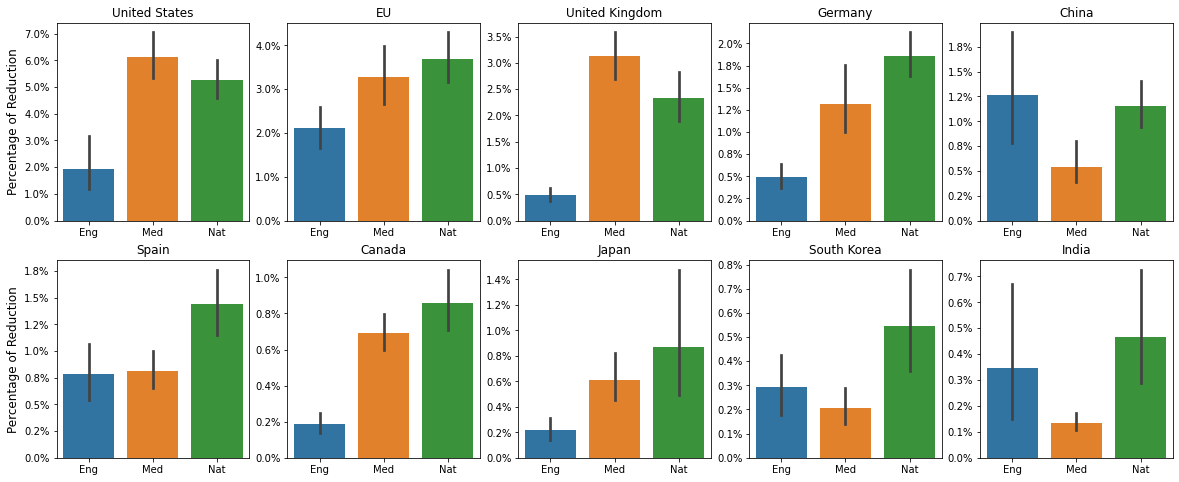

In [47]:
fig, axs=plt.subplots(nrows=2,ncols=5,figsize=(20,8))
axs = axs.reshape(-1)
for ind, ax in enumerate(axs):
    cntry = cntrylist[ind]
    sns.barplot(x='level',y='prop',data=rmvd_df[rmvd_df.cntry_source==cntry],ax=ax)
    ax.set_xlabel("")
    ax.set_title(cntry)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
    ax.set_ylabel("")
axs[0].set_ylabel("Percentage of Reduction",fontsize=12)
axs[5].set_ylabel("Percentage of Reduction",fontsize=12)
plt.savefig("impact.pdf")

In [50]:
cntry_info=pd.read_csv(cntry_info_path)[['wos_country','continent']]
cntry_info.head()

,wos_country,continent
0,Afghanistan,Asia
1,Albania,Europe
2,Algeria,Africa
3,American-Samoa,Oceania
4,Andorra,Europe


In [71]:
cntry_info[cntry_info.continent=='Oceania']

,wos_country,continent
3,American-Samoa,Oceania
10,Australia,Oceania
44,Cook Islands,Oceania
61,Federated States of Micronesia,Oceania
62,Fiji,Oceania
66,French-Polynesia,Oceania
97,Kiribati,Oceania
117,Marshall Islands,Oceania
129,Nauru,Oceania
132,New-Caledonia,Oceania


In [74]:
cntry_info=cntry_info.dropna()
rmvd_df = rmvd_df.merge(cntry_info,left_on='cntry',right_on='wos_country')

In [75]:
contslist = rmvd_df.continent.unique()

In [69]:
cntry_info.continent.unique()

array(['Asia', 'Europe', 'Africa', 'Oceania', nan, 'North America',
       'South America'], dtype=object)

Asia
Europe
Africa


<ipython-input-78-6dbce9639e4f>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
<ipython-input-78-6dbce9639e4f>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
<ipython-input-78-6dbce9639e4f>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


North America
South America
Oceania


<ipython-input-78-6dbce9639e4f>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
<ipython-input-78-6dbce9639e4f>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
<ipython-input-78-6dbce9639e4f>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


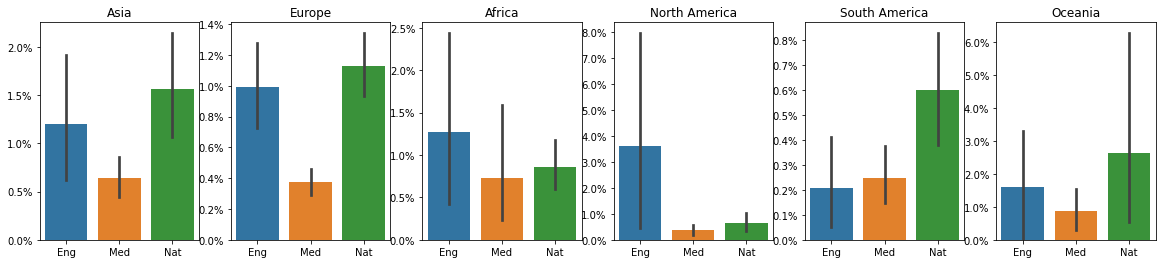

In [78]:
fig, axs=plt.subplots(nrows=1,ncols=6,figsize=(20,4))
for ind,ax in enumerate(axs):
    print(contslist[ind])
    sns.barplot(x='level',y='prop',data=rmvd_df[(rmvd_df.cntry_source=='China')
                                                &(rmvd_df.continent==contslist[ind])],ax=ax)
    ax.set_title(contslist[ind])
    ax.set_xlabel("")
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
    ax.set_ylabel("")

Asia
Europe
Africa
North America


<ipython-input-79-706cb52ad0ec>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
<ipython-input-79-706cb52ad0ec>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
<ipython-input-79-706cb52ad0ec>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
<ipython-input-79-706cb52ad0ec>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


South America
Oceania


<ipython-input-79-706cb52ad0ec>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
<ipython-input-79-706cb52ad0ec>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


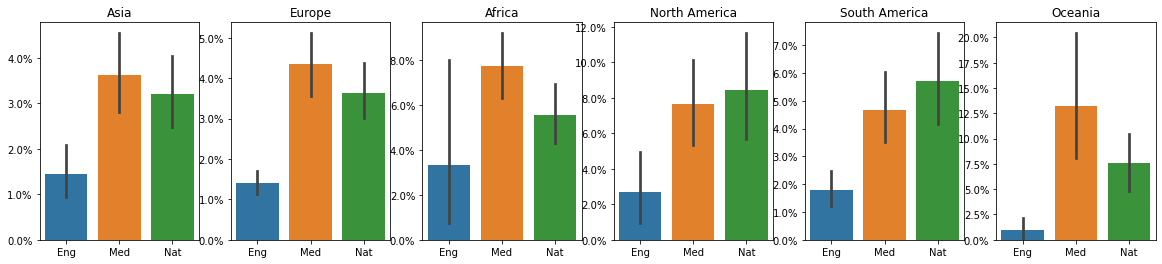

In [79]:
fig, axs=plt.subplots(nrows=1,ncols=6,figsize=(20,4))
for ind,ax in enumerate(axs):
    print(contslist[ind])
    sns.barplot(x='level',y='prop',data=rmvd_df[(rmvd_df.cntry_source=='United States')
                                                &(rmvd_df.continent==contslist[ind])],ax=ax)
    ax.set_title(contslist[ind])
    ax.set_xlabel("")
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
    ax.set_ylabel("")

Asia
Europe
Africa
North America


<ipython-input-80-b72ca6aa0185>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
<ipython-input-80-b72ca6aa0185>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
<ipython-input-80-b72ca6aa0185>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
<ipython-input-80-b72ca6aa0185>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


South America


<ipython-input-80-b72ca6aa0185>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
<ipython-input-80-b72ca6aa0185>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


Oceania


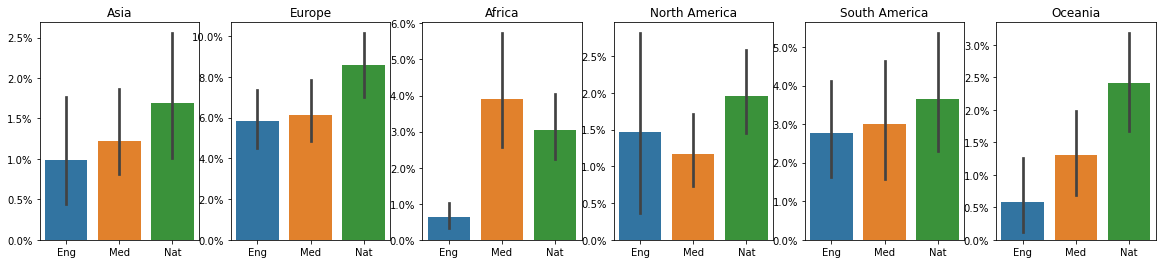

In [80]:
fig, axs=plt.subplots(nrows=1,ncols=6,figsize=(20,4))
for ind,ax in enumerate(axs):
    print(contslist[ind])
    sns.barplot(x='level',y='prop',data=rmvd_df[(rmvd_df.cntry_source=='EU')
                                                &(rmvd_df.continent==contslist[ind])],ax=ax)
    ax.set_title(contslist[ind])
    ax.set_xlabel("")
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
    ax.set_ylabel("")